## Solve 2D diffusion-advection equation in transient state for 2 cracks

In [1]:
import numpy as np
from mpi4py import MPI
import pyvista
import ufl

from ufl import Measure

import dolfinx
from dolfinx import fem, plot
from dolfinx.io import XDMFFile
from dolfinx.fem import FunctionSpace, VectorFunctionSpace, Constant, Function
from dolfinx.plot import create_vtk_mesh

from petsc4py import PETSc
from petsc4py.PETSc import ScalarType

## Read the mesh

In [2]:
# Read the mesh
with XDMFFile(MPI.COMM_WORLD, "mesh_2cracks/linear/2cracks2D_mesh.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    cell_tags = xdmf.read_meshtags(mesh, name="Grid")
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)

with XDMFFile(MPI.COMM_WORLD, "mesh_2cracks/linear/2cracks2D_facet_mesh.xdmf", "r") as xdmf:
    facet_tags = xdmf.read_meshtags(mesh, name="Grid")

In [3]:
# visualise the different materials
pyvista.set_jupyter_backend("pythreejs")

p = pyvista.Plotter(window_size=[800, 800], shape=(1,1))
# Filter out ghosted cells
num_cells_local = mesh.topology.index_map(mesh.topology.dim).size_local
marker = np.zeros(num_cells_local, dtype=np.int32)
cells_0 = cell_tags.indices[cell_tags.values == 5]
cells_1 = cell_tags.indices[cell_tags.values == 4]
cells_0 = cells_0[cells_0<num_cells_local]
cells_1 = cells_1[cells_1<num_cells_local]
marker[cells_0] = 1
marker[cells_1] = 2
topology, cell_types, x = create_vtk_mesh(mesh, mesh.topology.dim, np.arange(num_cells_local, dtype=np.int32))
grid = pyvista.UnstructuredGrid(topology, cell_types, x)
grid.cell_data["Marker"] = marker
grid.set_active_scalars("Marker")
actor0 = p.add_mesh(grid, show_edges=True)
if not pyvista.OFF_SCREEN:
    p.show()

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, 100000.0), qu…

## Define temporal parameters

In [4]:
t = 0 # Start time
T = 10000000. # 10000000. #100000 Final time
num_steps = 1000 # *100
dt = T / num_steps # time step size

Text = 10 # initial temperature and temperature on the far boundaries (L_ext)
Tinj = 80 # temperature of injected water

## Finite element function space

In [5]:
V = FunctionSpace(mesh, ("CG", 1))  # Lagrange element and and linear elements (degree 1)

## Set initial conditions

In [6]:
T_n = Function(V)
T_n.name = "T_n"
T_n.x.array[:] = np.full(len(T_n.x.array), Text)

### Store this initial condition in another variable because T_n will change at each iteration, and we need to keep the initial temperature for the calculation of the stores energy at the end

In [7]:
T_i = T_n.copy()
T_i.name = "T_i"

## Boundary conditions

In [8]:
# DIRICHLET: T=Ti on side 1
boundary_dofs_ext = fem.locate_dofs_topological(V, mesh.topology.dim-1, facet_tags.indices[facet_tags.values == 1])
bc_ext = fem.dirichletbc(ScalarType(Text), boundary_dofs_ext, V)
boundary_dofs_inj = fem.locate_dofs_topological(V, mesh.topology.dim-1, facet_tags.indices[(facet_tags.values == 2) | (facet_tags.values == 3)])
bc_inj = fem.dirichletbc(ScalarType(Tinj), boundary_dofs_inj, V)
# T=TI on side 3
#boundary_dofs = fem.locate_dofs_topological(V, mesh.topology.dim-1, facet_tags.indices[facet_tags.values == 3])
#bc_left = fem.dirichletbc(ScalarType(TI), boundary_dofs, V)

bc_tot = [bc_ext, bc_inj]

# NEUMANN: dp/dn=-10
# nothing

## Time-dependent output

In [9]:
T_h = T_n.copy()
T_h.name = "T_h"

## Trial and test functions

In [10]:
T, r = ufl.TrialFunction(V), ufl.TestFunction(V)

## Source term

In [11]:
# here f=0 as there is no source term
f = fem.Constant(mesh, ScalarType(0))

## Variational problem

In [12]:
# physical properties

scale = 1         # scale distance: 10m sur mesh = 1m en vrai

# for water
rho_w = 997*scale**3         # density of water in kg/m³
c_w = 4182/scale**2          # specific heat of water in J/(kg*K)
cond_w = 0.598/scale      # thermal conductivity of water in W/(m·K)

# for ceramic proppant   
# see the link: http://www.frackoptima.com/userguide/interface/materials-tab.html#proppants
rho_p = 1800*scale**3        # density of ceramic proppant in kg/m³
c_p = 1.6*10**6/1800/scale**2  # specific heat of ceramic proppant in J/(kg*K)
cond_p = 3/scale               # thermal conductivity of water in W/(m·K)
n = 0.4          # porosity

# for granite
rho_g = 2700*scale**3          # density of granite in kg/m³
c_g = 790/scale**2           # specific heat of granite in J/(kg*K)
cond_g = 3.2/scale        # thermal conductivity of granite in W/(m·K)

# get the homogenized parameters in the fracture
rho_h = (1-n)*rho_p + n*rho_w
c_h = (1-n)*c_p + n*c_w
cond_h = (1-n)*cond_p + n*cond_w

# give those different properties to the domain

M = FunctionSpace(mesh, ("DG", 0))
# materials
rock_mask = (cell_tags.values == 4)
fracture_mask = (cell_tags.values == 5)
# parameters
rho = Function(M)
rho.x.array[rock_mask] = np.full(rock_mask.sum(), rho_g)
rho.x.array[fracture_mask] = np.full(fracture_mask.sum(), rho_h)

c = Function(M)
c.x.array[rock_mask] = np.full(rock_mask.sum(), c_g)
c.x.array[fracture_mask] = np.full(fracture_mask.sum(), c_h)

cond = Function(M)
cond.x.array[rock_mask] = np.full(rock_mask.sum(), cond_g)
cond.x.array[fracture_mask] = np.full(fracture_mask.sum(), cond_h)

In [13]:
# define constant flux in the fracture and 0 flux on the rock
Q = VectorFunctionSpace(mesh, ("DG", 0))   # ("DG", 0)
q = Function(Q)
num_cells = mesh.topology.index_map(mesh.topology.dim).size_local   # number of cells (here it is equal to the number of dofmap, see explanation below)
block_size = Q.dofmap.index_map_bs  # number of dof per dofmap
for i in range(num_cells):
    if cell_tags.values[i] == 5:
        q.x.array[[i*block_size, i*block_size+1]] = [1., 0]  # 1.
    elif cell_tags.values[i] == 4:
        q.x.array[[i*block_size, i*block_size+1]] = [0, 0]

In [14]:
# plot velocity field
from dolfinx.mesh import compute_midpoints
plotter = pyvista.Plotter()
#plotter.set_position([0,0,5])

# We include ghosts cells as we access all degrees of freedom (including ghosts) on each process
top_imap = mesh.topology.index_map(mesh.topology.dim)
num_cells = top_imap.size_local + top_imap.num_ghosts
midpoints = compute_midpoints(mesh, mesh.topology.dim, range(num_cells))

num_dofs = Q.dofmap.index_map.size_local +  Q.dofmap.index_map.num_ghosts
assert(num_cells == num_dofs)
values = np.zeros((num_dofs, 3), dtype=np.float64)
values[:, :mesh.geometry.dim] = q.x.array.real.reshape(num_dofs, Q.dofmap.index_map_bs)
cloud = pyvista.PolyData(midpoints)
cloud["q"] = values
glyphs = cloud.glyph("q", factor=1e-1)
actor = plotter.add_mesh(grid, style="wireframe", color="k")
actor2 = plotter.add_mesh(glyphs)

if not pyvista.OFF_SCREEN:
    plotter.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

In [15]:
F = T * r * ufl.dx + dt * cond/(rho*c) * ufl.dot(ufl.grad(T), ufl.grad(r)) * ufl.dx + dt * (rho_w*c_w)/(rho*c) * ufl.dot(q, ufl.grad(T)) * r * ufl.dx \
    - (T_n * r * ufl.dx + dt * f * r * ufl.dx)  # - dt * cond/(rho*c) * g * r * ds(2)) no Neumann conditions

In [16]:
a = ufl.lhs(F)
L = ufl.rhs(F)

## Preparation of linear algebra structures for time dependent problems

In [17]:
bilinear_form = fem.form(a)
linear_form = fem.form(L)

In [18]:
# bilinear_form (a) isn't time dependant so we can assemble it once (we could do the same for the integral of the Neumann term as the flux is contant, but for now let's stay like that)
A = fem.petsc.assemble_matrix(bilinear_form, bcs=bc_tot)
A.assemble()
b = fem.petsc.create_vector(linear_form)

## Linear solver

In [19]:
# here matrix A is already assembled so we don't need to use petsc.LinearProblem like in tuto1
solver = PETSc.KSP().create(mesh.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

In [20]:
import pyvista
pyvista.set_jupyter_backend("ipygany")

grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(V))

def plot_function(t, uh):
    """
    Create a figure of the concentration uh warped visualized in 3D at timet step t.
    """
    p = pyvista.Plotter()
    # Update point values on pyvista grid
    grid.point_data[f"u({t})"] = uh.x.array.real
    # Warp mesh by point values
    warped = grid.warp_by_scalar(f"u({t})", factor=1)  #1.5

    # Add mesh to plotter and visualize in notebook or save as figure
    actor = p.add_mesh(warped)
    if not pyvista.OFF_SCREEN:
        p.show()
    else:
        pyvista.start_xvfb()
        figure_as_array = p.screenshot(f"diffusion_{t:.2f}.png")
        # Clear plotter for next plot
        p.remove_actor(actor)
plot_function(0, T_h)

AppLayout(children=(VBox(children=(HTML(value='<h3>u(0)</h3>'), Dropdown(description='Colormap:', options={'Br…

In [21]:
T_vec = [] # for saving
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    fem.petsc.assemble_vector(b, linear_form)
    
    # Apply Dirichlet boundary condition to the vector
    fem.petsc.apply_lifting(b, [bilinear_form], [bc_tot])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, bc_tot)

    # Solve linear problem
    solver.solve(b, T_h.vector)
    T_h.x.scatter_forward()

    # Update solution at previous time step (u_n)
    T_n.x.array[:] = T_h.x.array
        
    if i % 200 == 0:
        plot_function(t, T_h)
        
    if t == 10000 or t == 100000 or t == 1000000 or t == 10000000:
        # also save the values
        T_vec.append(T_h.x.array[(mesh.geometry.x[:,0]>=20-0.1) & (mesh.geometry.x[:,0]<=20+0.1) & (mesh.geometry.x[:,1]>=35) & (mesh.geometry.x[:,1]<=45)])

AppLayout(children=(VBox(children=(HTML(value='<h3>u(10000.0)</h3>'), Dropdown(description='Colormap:', option…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(2010000.0)</h3>'), Dropdown(description='Colormap:', opti…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(4010000.0)</h3>'), Dropdown(description='Colormap:', opti…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(6010000.0)</h3>'), Dropdown(description='Colormap:', opti…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(8010000.0)</h3>'), Dropdown(description='Colormap:', opti…

## Compute the stored energy

In [22]:
# define custom integration to integrate only over rock domain
dx_rock = Measure("dx", domain=mesh, subdomain_data=cell_tags)

I = fem.form(rho * c * (T_h-T_i) * dx_rock(4))
stored_energy = fem.assemble_scalar(I)
stored_energy # stored energy in J/m

80477283378.73146

In [23]:
stored_energy/1000000  # stored energy in MJ/m

80477.28337873146

## Verify the solution 

In [24]:
import math

In [25]:
def T_analytical(T0, Ti, diff, x, t):
    return T0 + (Ti-T0)*math.erf(x/math.sqrt(4*diff*t))

In [26]:
diff_g = cond_g/(rho_g*c_g)   # diffusivity of granite
h = 5                        # length between the 2 cracks

In [27]:
T_analytical(Tinj, Text, diff_g, h, 10000000)

35.294356104802745

In [28]:
10000000/(60*60)

2777.777777777778

In [29]:
10000000/(60*60*24*31)  # number of month

3.7335722819593786

## Plot to visualise final profile as a function of velocity

In [30]:
import matplotlib.pyplot as plt

In [31]:
# look for the temperature distribution between the two cracks for some given x=20m
x_axis = mesh.geometry.x[(mesh.geometry.x[:,0]>=20-0.1) & (mesh.geometry.x[:,0]<=20+0.1) & (mesh.geometry.x[:,1]>35) & (mesh.geometry.x[:,1]<45)][:,1]
T_axis = T_h.x.array[(mesh.geometry.x[:,0]>=20-0.1) & (mesh.geometry.x[:,0]<=20+0.1) & (mesh.geometry.x[:,1]>=35) & (mesh.geometry.x[:,1]<=45)]
# sort these pressures according to the radial distance from point A 
index_order = np.argsort(x_axis)
x_numerical = x_axis[index_order]
T_numerical = T_axis[index_order]
#np.save("saved_data/velocity1.npy", T_numerical)

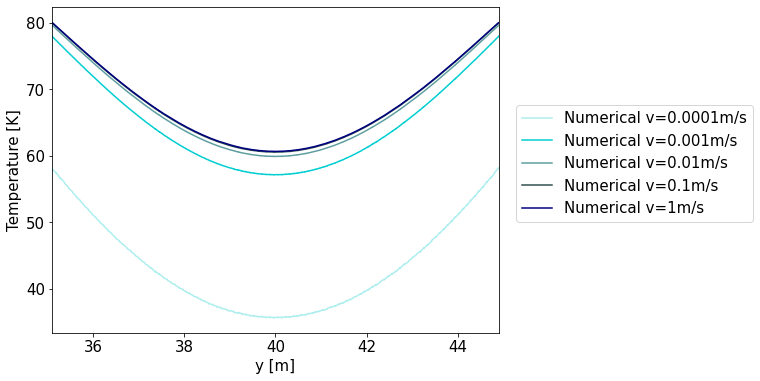

In [32]:
import os
# plot with matplotlib

# x axis for analytical solution
x = np.arange(0., 5-0.1, 0.001)
# compute analytical solution for all points
T_analytical_v = []
for x_i in x:
    T_analytical_v.append(T_analytical(Tinj, Text, diff_g, x_i, 10000000))
T_analytical_v = np.array(T_analytical_v)

# plot
#plt.plot(x+35.1, T_analytical_v, 'r--', x+35.1+5-0.1, T_analytical_v[::-1], 'r--', x_numerical, T_numerical, '*')
#plt.xlim(35+0.1, 45-0.1)
#plt.show()
plt.figure(figsize=(8, 6))
colours = ["paleturquoise", "darkturquoise", "cadetblue", "darkslategray", "navy"]
for ind, file in enumerate(sorted(os.listdir("saved_data"))):
    T_axis = np.load("saved_data/"+file)
    plt.plot(x_numerical, T_axis, '-', c = colours[ind])
#plt.plot(x+35.1, T_analytical_v, 'r--')
#plt.plot(x+35.1+5-0.1, T_analytical_v[::-1], 'r--')
plt.legend(["Numerical v=0.0001m/s", "Numerical v=0.001m/s", "Numerical v=0.01m/s", "Numerical v=0.1m/s", "Numerical v=1m/s", "1D Analytical for v=1m/s"], loc=(1.04,0.34), fontsize = 15)
plt.xlim(35+0.1, 45-0.1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('y [m]', fontsize=15)
plt.ylabel('Temperature [K]', fontsize=15) 
plt.savefig("2cracksVelocityEvolution.png", bbox_inches="tight")
plt.show()

## Plot the stored energy as a function of velocity

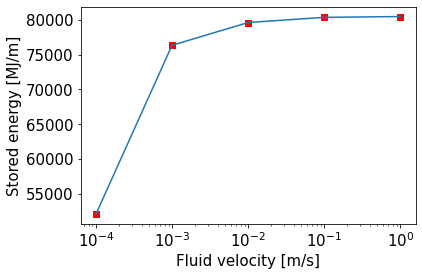

In [33]:
# this data has been saved "by hand" by looking at the stored energy for each simulation for a given velocity
v = [0.0001, 0.001, 0.01, 0.1, 1.]
E = [52021, 76336, 79617, 80361, 80477]
plt.plot(v, E)
plt.scatter(v, E, marker=',', c='r')
plt.xscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Fluid velocity [m/s]', fontsize=15)
plt.ylabel('Stored energy [MJ/m]', fontsize=15) 
plt.savefig("2cracksEnergyEvolution.png", bbox_inches="tight")
plt.show()

## Plot to visualise profile as a function of time

In [34]:
# look for the pressures on L_bottom
x_axis = mesh.geometry.x[(mesh.geometry.x[:,0]>=20-0.1) & (mesh.geometry.x[:,0]<=20+0.1) & (mesh.geometry.x[:,1]>35) & (mesh.geometry.x[:,1]<45)][:,1]
index_order = np.argsort(x_axis)
x_numerical = x_axis[index_order]
for ind, T_axis in enumerate(T_vec):
    T_vec[ind] = T_axis[index_order]
len(T_vec)

4

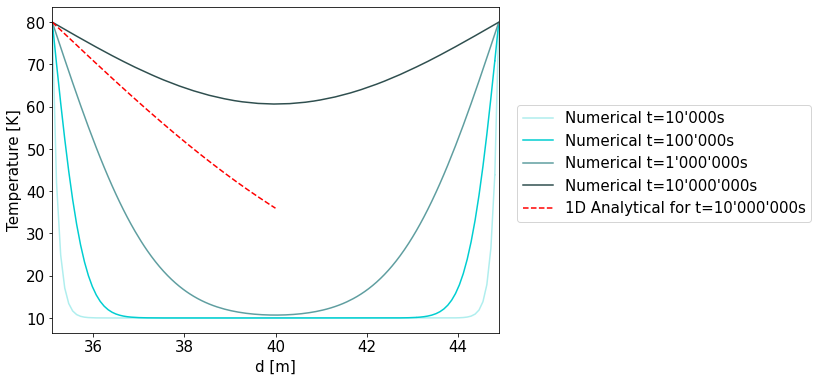

In [35]:
# plot with matplotlib

# x axis for analytical solution
x = np.arange(0., 5-0.1, 0.001)

# plot
plt.figure(figsize=(8, 6))
colours = ["paleturquoise", "darkturquoise", "cadetblue", "darkslategray"]
for ind, T_axis in enumerate(T_vec):
    plt.plot(x_numerical, T_axis, '-', c = colours[ind])
plt.plot(x+35.1, T_analytical_v, 'r--')
#plt.plot(x+35.1+5-0.1, T_analytical_v[::-1], 'r--')
plt.legend(["Numerical t=10'000s", "Numerical t=100'000s", "Numerical t=1'000'000s", "Numerical t=10'000'000s", "1D Analytical for t=10'000'000s"], loc=(1.04,0.34), fontsize = 15)
plt.xlim(35+0.1, 45-0.1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('d [m]', fontsize=15)
plt.ylabel('Temperature [K]', fontsize=15) 
plt.savefig("2cracksTimeEvolution.png", bbox_inches="tight")
plt.show()